# テンソルネットワークのサンプル

参考資料
<https://zenn.dev/torataro/articles/2023-11-12-tensor_network>

以下のような計算を考える
$$
w_i = \sum_j A_{ij} v_j
$$

実際の値としては、

$$
v = \begin{pmatrix} 1 \\ 2\end{pmatrix} \newline
A = \begin{pmatrix} 1 & 2 \\ 3 & 4\end{pmatrix}

$$

In [21]:
import numpy as np
import tensornetwork as tn # TensorNetworkライブラリのインポート

v = np.array([1,2]) # ベクトルvの定義
A = np.array([[1,2],[3,4]]) # 行列Aの定義

v_Node = tn.Node(v, name="vector_v") # ベクトルvのノードの定義
A_Node = tn.Node(A, name="matrix_A") # 行列Aのノードの定義

In [22]:
# check
print(type(A_Node))
print(A_Node.name)
print(A_Node.tensor)
print(A_Node.edges)

<class 'tensornetwork.network_components.Node'>
matrix_A
[[1 2]
 [3 4]]
[
Edge(Dangling Edge)[0] 
, 
Edge(Dangling Edge)[1] 
]


In [23]:
A_Node[0]  # A_Node.edges[0]と同様の動きをする


Edge(Dangling Edge)[0] 

ここで、A_Node[0]が添え字のi, A_Node[1]が添え字のjに対応する状態となっている。

In [24]:
# エッジの結合　A_ij vj　を生成する
connect = tn.connect(A_Node[1], v_Node[0])

In [25]:
# 縮約
w_Node = tn.contract(connect)
# 結果を表示する
w_Node.tensor

array([ 5, 11])

In [26]:
# contractors.autoを使うと便利に縮約ができる。
v = np.array([1,2]) # ベクトルvの定義
A = np.array([[1,2],[3,4]]) # 行列Aの定義
B = np.array([[1,0],[0,-1]])

v_Node = tn.Node(v, name="vector_v") # ベクトルvのノードの定義
A_Node = tn.Node(A, name="matrix_A") # 行列Aのノードの定義
B_Node = tn.Node(B, name="matrix_B")

tn.connect(A_Node[1], v_Node[0]) # 脚の結合
tn.connect(B_Node[1], A_Node[0]) # 脚の結合

w_Node = tn.contractors.auto( # 縮約する
    nodes=[v_Node, A_Node, B_Node],
    output_edge_order=[B_Node[0]]
)
w_Node.tensor # 結果表示

array([  5, -11])

量子もつれをTNで計算する

下記の回路をテンソルネットワーク化すると、
q0,q1,q'0,q'1は1脚、Hは2脚、CXは4脚のテンソルとなる。

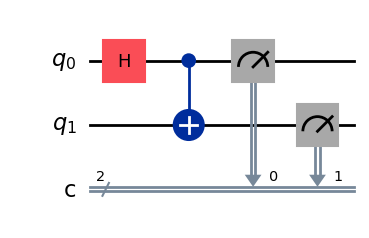

In [29]:
# qiskitで回路図を確認する
from qiskit import QuantumCircuit
qc = QuantumCircuit(2,2)

# ゲートを適用します。
qc.h(0)
qc.cx(0,1)

# 測定ゲートを追加
qc.measure(0, 0)
qc.measure(1, 1)

# 回路を描画
qc.draw(output="mpl")

In [31]:
# 各種必要なゲート操作(行列を定義)
O  = np.array([[0, 0],[0, 0]])  # ゼロ行列
I  = np.array([[1, 0],[0, 1]])  # 単位行列
X  = np.array([[0, 1],[1, 0]])  # Xゲート
H  = np.array([[1, 1],[1,-1]]) / np.sqrt(2) # アダマールゲート定義
CX = np.array([[I, O],[O, X]]) # CXゲート定義
# 状態定義
zero_state = np.array([1, 0]) # |0>状態定義
one_state  = np.array([0, 1]) # |1>状態定義

In [32]:
# ノード化
H_node  = tn.Node(H, name="Hadamard Gate") # アダマールゲートノード化
CX_node = tn.Node(CX, name="Controlled NOT Gate") # CXゲートノード化
init_node_1 = tn.Node(zero_state, name="zero_init_state") # 初期状態|q_1>=|0>ノード化
init_node_0 = tn.Node(zero_state, name="zero_init_state") # 初期状態|q_0>=|0>ノード化
zero_final_node_1 = tn.Node(zero_state, name="zero_final_state") # 終状態|q'_1>=|0>ノード化
zero_final_node_0 = tn.Node(zero_state, name="zero_final_state") # 終状態|q'_0>=|0>ノード化
one_final_node_1  = tn.Node(one_state, name="one_final_state") # 終状態|q'_1>=|1>ノード化
one_final_node_0  = tn.Node(one_state, name="one_final_state") # 終状態|q'_0>=|1>ノード化


In [38]:
# |00> を設定 -> 解が0.5
# final_node_1 = zero_final_node_1 # 終状態の設定|q'_1>
# final_node_0 = zero_final_node_0 # 終状態の設定|q'_0>

# |01> を設定 -> 解が0
# final_node_1 = zero_final_node_1 # 終状態の設定|q'_1>
# final_node_0 = one_final_node_0 # 終状態の設定|q'_0>

# |10> を設定 -> 解が0
# final_node_1 = one_final_node_1 # 終状態の設定|q'_1>
# final_node_0 = zero_final_node_0 # 終状態の設定|q'_0>

# |11> を設定 -> 解が0.5
final_node_1 = one_final_node_1 # 終状態の設定|q'_1>
final_node_0 = one_final_node_0 # 終状態の設定|q'_0>

In [39]:

# |q_1>から|q'_1>までの脚の結合
tn.connect(H_node[1], init_node_1[0])   # 初期状態|q_1>とアダマールゲートの結合
tn.connect(CX_node[1], H_node[0])       # アダマールゲートとCXゲートの結合
tn.connect(final_node_1[0], CX_node[0]) # CXゲートと終状態|q'_1>の結合
# |q_0>から|q'_0>までの脚の結合
tn.connect(CX_node[3], init_node_0[0])  # 初期状態|q_0>とCXゲートの結合
tn.connect(final_node_0[0], CX_node[2]) # CXゲートと終状態|q'_0>の結合

# 縮約
result = tn.contractors.auto(
    [init_node_1, init_node_0, H_node, CX_node, final_node_1, final_node_0]
)

# 確率計算
np.abs(result.tensor)**2

0.4999999999999999

 > Counts: {'11': 524, '00': 500}


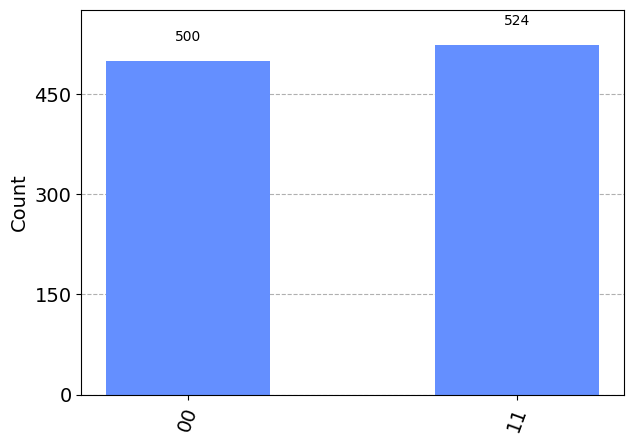

In [28]:
# # 補足：qiskitで計測して、00,11が観測されることを確認する。
# from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
# from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit_aer import AerSimulator
# # シミュレーターで実験
# backend = AerSimulator()
# # 回路を最適化
# pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
# isa_qc = pm.run(qc)
# # Samplerで実行
# sampler = Sampler(backend)
# job = sampler.run([isa_qc])
# result = job.result()

# #  測定された回数を表示
# counts = result[0].data.c.get_counts()
# print(f" > Counts: {counts}")

# ## ヒストグラムで測定された確率をプロット
# from qiskit.visualization import plot_histogram
# plot_histogram(counts)